In [1]:
from glio2.imports import *
from glio2 import nn as g2nn
from glio2.datasets import get_MNIST
import torchzero as tz
print('imports done')

ds = get_MNIST()
dstrain, dstest = ds.split(0.8, shuffle=False)

print(len(dstrain), len(dstest))

imports done
56000 14000


In [2]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28*28, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 10)
        self.act = nn.ReLU()
        #self.softmax = nn.Softmax(dim=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.act(self.l1(self.flatten(x)))
        x = self.act(self.l2(x))
        x = self.l3(x)
        return x

In [3]:
dltrain = DataLoader(dstrain, 128, shuffle=True) # type:ignore
dltest = DataLoader(dstest, 128) # type:ignore

print(len(dltrain), len(dltest))

class PrintProgress(Callback):
    def after_any_epoch(self, learner: Learner):
        print(f'Finished {learner.cur_epoch}th {learner.status} epoch                                                               ')

    def after_any_batch(self, learner: Learner):
        print(f'Finished {learner.cur_batch}th {learner.status} batch in {learner.cur_epoch} epoch, loss = {learner.loss}', end = '\r')

callbacks = [
    CB.Accelerate(),
    CB.LogLoss(),
    CB.LogTime(),
    CB.test_epoch(dltest, 512),
    CB.FastProgress(bar_step = 2, plot_step=64),
]

model = MLP().to(CUDA)
opt = Sig(torch.optim.SGD, model.parameters(), lr = 1e-1)

learner = Learner(callbacks, model, loss_fn=nn.CrossEntropyLoss(), optimizer=opt, )
learner.add_named_info('transforms', norm = 'znorm')

438 110


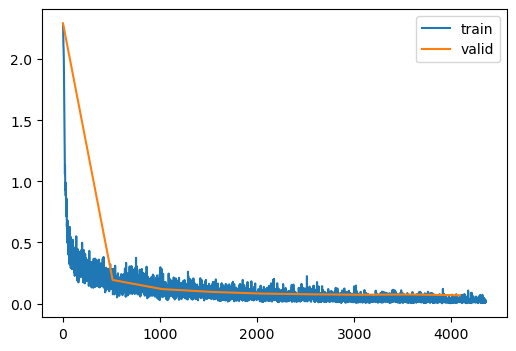

In [4]:
learner.fit(dltrain, 10)

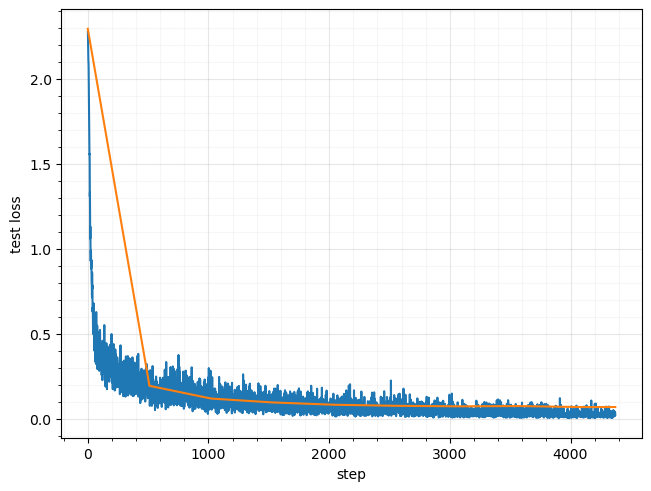

In [5]:
learner.logger.plot('train loss', 'test loss',).show()